# Notebook 02: Gold Standard Labels Generation for Judge Training

## 📋 **Overview**
This notebook generates **gold standard labels** for training DSPy judges by using Claude 4.5 Sonnet as a "Subject Matter Expert" (SME) to evaluate customer support conversations. It creates human-quality judgments that will serve as ground truth labels for optimizing our DSPy judge in Notebook 03.

## 🔄 **Complete Workflow with Example**

Continuing from Notebooks 00-01, let's trace how our flight booking conversation becomes a labeled training example:

### **Starting Point (from Notebook 01)**
We begin with the structured training data from Notebook 01's output:

**Training Example Structure:**
```python
{
  'conversation_id': 'Session:2057187615:12852',
  'conversation': "Customer: i just booked my flight...",  # Original full conversation
  'truncated_conversation': "Customer: i just booked...",   # Incomplete scenario  
  'company_and_transcript': "Company: Southwest Airlines\nTranscript so far: Customer: i just booked my flight...",
  'llm_response': "Thank you for providing that information. I found your booking!...",  # Baseline response
  'output_transcript': "Company: Southwest Airlines\nTranscript so far: Customer: i just booked my flight and i have received a email but im not sure if it went through or not, i cant go to the web site and see my itinerary\nAgent: Hello! I understand your concern...\nSupport: Thank you for providing that information. I found your booking! Your confirmation code is ABC123."
}
```

### **Phase 1: Test Dataset Selection**
1. **Load train/test splits** from `datasets/preprocessed_dev_judge_dataset_split/`
2. **Use test split** for gold standard generation (20 examples)
3. **Extract conversation transcripts** with complete agent responses

**Our Flight Booking Example becomes:**
```
Input for Gold Standard Judge:
Company: Southwest Airlines
Transcript so far: Customer: i just booked my flight and i have received a email but im not sure if it went through or not, i cant go to the web site and see my itinerary
Agent: Hello! I understand your concern about your flight booking. Let me help you verify your reservation.
Customer: The email just says payment received with an order number, no confirmation code
Agent: I can look up your booking with the order number. Can you provide that along with your full name?
Customer: Order #12345, John Smith
Support: Thank you for providing that information. I found your booking! Your confirmation code is ABC123. Your flight is confirmed for tomorrow at 2:30 PM.
```

### **Phase 2: Gold Standard Judge Setup**
4. **Configure Claude 4.5 Sonnet** as expert judge with `SupportTranscriptJudge` signature
5. **Use DSPy ChainOfThought** for structured reasoning and judgment
6. **Set temperature=0** for consistent, deterministic judgments

**Judge Configuration:**
```python
dspy_config = {
    "model_name": "claude-sonnet-4-5-20250929",  # Latest Claude 4.5 Sonnet
    "api_key": secrets["ANTHROPIC_API_KEY"],
    "temperature": 0  # Deterministic judgments
}

judge = dspy.ChainOfThought(SupportTranscriptJudge)
# Signature: transcript (input) → reasoning + satisfied (outputs)
```

### **Phase 3: Expert Evaluation**
7. **Process each transcript** through Claude for expert evaluation
8. **Generate reasoning** explaining the satisfaction judgment
9. **Produce binary labels** (True/False) for customer satisfaction

**Example Gold Standard Evaluation:**
```python
# Input to Claude
transcript = "Company: Southwest Airlines\nTranscript so far: Customer: i just booked my flight..."

# Claude's Expert Judgment
{
  "reasoning": "The agent successfully resolved the customer's booking concern by locating the reservation and providing the confirmation code. The customer's initial worry about whether the booking went through was addressed completely, and flight details were confirmed.",
  "satisfied": "true"
}
```

### **Phase 4: Gold Standard Dataset Creation**
10. **Extract structured labels** from Claude's responses
11. **Save gold standard dataset** to `datasets/gold_standard_judge_result/`
12. **Create training examples** for DSPy judge optimization

**Final Gold Standard Structure:**
```python
{
  'conversation_id': 'Session:2057187615:12852',
  'output_transcript': "Company: Southwest Airlines\nTranscript so far...",
  'dspy_response': {
    'reasoning': "The agent successfully resolved the customer's booking concern...",
    'satisfied': "true"  
  },
  'explanation': "The agent successfully resolved the customer's booking concern...",  # Extracted
  'satisfied': "true"  # Extracted for easy access
}
```

## 🎯 **Key Components**

### **SupportTranscriptJudge Signature**
```python
class SupportTranscriptJudge(dspy.Signature):
    transcript: str = dspy.InputField(desc="Input transcript to judge")
    satisfied: str = dspy.OutputField(desc="Whether the agent satisfied the customer query. This must be either True or False")
```

### **Claude 4.5 Sonnet as SME**
- **Expert-level reasoning**: Provides human-quality judgment explanations
- **Consistent evaluation**: Temperature=0 ensures reproducible labels
- **Binary satisfaction**: Clear True/False labels for optimization

### **ChainOfThought Processing**
- **Structured reasoning**: Forces Claude to explain its judgment
- **Quality assurance**: Reasoning helps validate label correctness
- **Training richness**: Provides examples of good evaluation logic

## 🔗 **Data Flow Transformation**
1. **Training Examples** (Notebook 01) → **Selected Test Cases** (Phase 1)
2. **Test Conversations** → **Expert Judgments** (Phase 3)
3. **Claude Evaluations** → **Gold Standard Labels** (Phase 4)

## 📁 **File Organization**
- **Input**: `datasets/preprocessed_dev_judge_dataset_split/test/` (20 examples from Notebook 01)
- **Output**: `datasets/gold_standard_judge_result/` (labeled training data)
- **Model**: Claude 4.5 Sonnet via Anthropic API

## 🎓 **Pipeline Integration**
This notebook serves as the **ground truth generation phase**:
- **Consumes**: Structured training examples from Notebook 01
- **Produces**: Expert-labeled satisfaction judgments
- **Enables**: Judge optimization in Notebook 03 with high-quality training data
- **Quality**: Claude 4.5 Sonnet provides human-level evaluation quality

The gold standard labels become the "correct answers" that teach our DSPy judge how to properly evaluate customer support conversations!

In [32]:
# Reload modules to get the latest version with null handling fix
%load_ext autoreload
%autoreload 2

print("🔄 Reloaded modules with null handling fix for extract_llm_response_fields_dspy")

🔄 Reloaded modules with null handling fix for extract_llm_response_fields_dspy


# Gold standard judge dataset
This is the equivalent of SME labelling

In [33]:
from dspy_judge.llm_caller.utils import load_secrets
from dspy_judge.data_loader.dataset_loader import CustomerSupportDatasetLoader
from dspy_judge.processor.parallel_processor import ParallelProcessor
from dspy_judge.prompts.dspy_signatures import SupportTranscriptJudge
from dspy_judge.processor.utils import convert_dataset_to_dspy_examples, extract_llm_response_fields_dspy
from dspy_judge.processor.parallel_processor import ParallelProcessor
from dspy_judge.metrics import match_judge_metric
from dspy_judge.plotting import plot_judge_results
import numpy as np
from sklearn.metrics import cohen_kappa_score
import dspy

In [34]:
secrets = load_secrets()

## Load split dataset (final output of notebook 1)

In [35]:
data_loader = CustomerSupportDatasetLoader()
split_dataset = data_loader.load_local_dataset("datasets/preprocessed_dev_judge_dataset_split/")

2025-11-06 20:25:05 - dspy_judge.data_loader.dataset_loader - INFO - Local dataset loaded from datasets/preprocessed_dev_judge_dataset_split/. Size: 2


In [39]:
dev_dataset = split_dataset["train"]
judge_dataset = split_dataset["test"]

In [44]:
# Print first row text values for dspy_response, llm_response, and output_transcript
first = judge_dataset[0]

def extract_text(val):
    if isinstance(val, dict):
        return val.get('llm_response') or val.get('response') or str(val)
    return str(val)

print("dspy_response (text):")
print(extract_text(first.get('dspy_response')))

print("\nllm_response:")
print(first.get('llm_response'))

print("\noutput_transcript:")
print(first.get('output_transcript'))

dspy_response (text):
I understand the confusion. In the USA, you generally must be 21 to purchase or consume alcohol, including duty-free purchases. Bringing alcohol from the UK to the US has specific regulations, and you may need to declare it at customs. I recommend checking with the relevant authorities for accurate information on this matter.

llm_response:
Company: Delta Airlines
Conversation:
Customer: If you are 18 years old and in the UK and flying to the USA. How does it work with the age differences in being able to drink alcohol between the 2 countries?
Support: Hello. Delta's policy for serving alcohol on board requires passengers to be 21 years or older, regardless of their departure country or destination.
Customer: So I can't drink anything on the flight then, even though I'm 18 and legally drink in the UK? What about once I land in the USA?
Support: That's correct, you must be 21 to consume alcohol on a Delta flight. Upon arrival in the USA, local and federal laws rega

In [72]:
# Let's investigate why we got "No conversation generated"
print("🔍 INVESTIGATING 'No conversation generated' case")
print("="*60)

# Look at the first example in detail
example = judge_dataset[0]
print(f"conversation_id: {example['conversation_id']}")
print(f"company: {example['company']}")

print(f"\nOriginal conversation:")
print(f"'{example['conversation']}'")

print(f"\nTruncated conversation:")
print(f"'{example['truncated_conversation']}'")

print(f"\ncompany_and_transcript:")
print(f"'{example['company_and_transcript']}'")

print(f"\noutput_transcript:")
print(f"'{example['output_transcript']}'")

# Check conversation length
print(f"\nConversation analysis:")
print(f"  Original conversation length: {len(example['conversation'])} chars")
print(f"  Truncated conversation length: {len(example['truncated_conversation'])} chars")
print(f"  Number of words: {example.get('number_of_words', 'N/A')}")
print(f"  Conversation word count: {example.get('conversation_word_count', 'N/A')}")

🔍 INVESTIGATING 'No conversation generated' case
conversation_id: Session:2057187618:22093
company: Delta Airlines

Original conversation:
'Customer: If you are 18 years old and in the UK and flying to the USA. How does it work with the age differences in being able to drink alcohol between the 2 countries?
Support: Hello. Delta's policy for serving alcohol on board requires passengers to be 21 years or older, regardless of their departure country or destination.
Customer: So I can't drink anything on the flight then, even though I'm 18 and legally drink in the UK? What about once I land in the USA?
Support: That's correct, you must be 21 to consume alcohol on a Delta flight. Upon arrival in the USA, local and federal laws regarding alcohol consumption will apply.
Customer: Does that mean I can't purchase duty-free alcohol at the airport in the US if I'm 18? Or bring any from the UK? This is all very confusing.
Support: Delta does not offer legal advice. Any purchase or possession of a

In [71]:
# Check if this pattern appears in other examples
print("\n🔍 CHECKING FOR PATTERN ACROSS EXAMPLES")
print("="*60)

no_conversation_count = 0
total_examples = min(10, len(judge_dataset))

for i in range(total_examples):
    example = judge_dataset[i]
    conversation = example['conversation']
    
    if "No conversation generated" in conversation:
        no_conversation_count += 1
        print(f"Example {i}: ❌ 'No conversation generated' (conversation_id: {example['conversation_id']})")
    else:
        print(f"Example {i}: ✅ Valid conversation (length: {len(conversation)} chars)")
        # Show first 100 chars of valid conversations
        print(f"    Preview: {conversation[:100]}...")

print(f"\nSummary: {no_conversation_count}/{total_examples} examples have 'No conversation generated'")

# Let's also check the original dataset to understand this better
print(f"\n📊 DATASET STATISTICS")
print(f"Judge dataset size: {len(judge_dataset)}")
print(f"Dev dataset size: {len(dev_dataset)}")

# Check how many total examples have this issue
no_conv_total = sum(1 for example in judge_dataset if "No conversation generated" in example['conversation'])
print(f"Total examples with 'No conversation generated': {no_conv_total}/{len(judge_dataset)}")


🔍 CHECKING FOR PATTERN ACROSS EXAMPLES
Example 0: ✅ Valid conversation (length: 963 chars)
    Preview: Customer: If you are 18 years old and in the UK and flying to the USA. How does it work with the age...
Example 1: ✅ Valid conversation (length: 929 chars)
    Preview: Customer: I want to travel on 20 Nov from NFK to WAS on 84 NE Regional, then take Aceila to Providen...
Example 2: ✅ Valid conversation (length: 925 chars)
    Preview: Customer: We left an electronic device on --- 1132 cancun to Denver yesterday evening 2-2-13, how ma...
Example 3: ✅ Valid conversation (length: 930 chars)
    Preview: Customer: I am flying from home(international)-PHL-LGA and then on the return segment LGA-CTL-home(I...
Example 4: ✅ Valid conversation (length: 711 chars)
    Preview: Customer: How long does it take for a password reset to become activated. I just changed mine but th...
Example 5: ✅ Valid conversation (length: 887 chars)
    Preview: Customer: on flight number 578 tomorrow from Chica

In [73]:
# Quick check - what's actually in the current judge_dataset?
print("🔍 CURRENT JUDGE DATASET STATUS")
print("="*50)

first_example = judge_dataset[0]
print(f"First example conversation: '{first_example['conversation'][:100]}...'")
print(f"Conversation length: {len(first_example['conversation'])} chars")

# Check for both patterns
no_conv_count = sum(1 for e in judge_dataset if "No conversation generated" in e.get('conversation', ''))
empty_conv_count = sum(1 for e in judge_dataset if len(e.get('conversation', '').strip()) == 0)

print(f"\nCurrent judge_dataset analysis:")
print(f"  'No conversation generated': {no_conv_count}/{len(judge_dataset)}")
print(f"  Empty conversations: {empty_conv_count}/{len(judge_dataset)}")  
print(f"  Valid conversations: {len(judge_dataset) - no_conv_count - empty_conv_count}/{len(judge_dataset)}")

# Show conversation_ids to see if this is the same dataset
print(f"\nFirst 3 conversation IDs:")
for i in range(3):
    print(f"  {i}: {judge_dataset[i]['conversation_id']}")

🔍 CURRENT JUDGE DATASET STATUS
First example conversation: 'Customer: If you are 18 years old and in the UK and flying to the USA. How does it work with the age...'
Conversation length: 963 chars

Current judge_dataset analysis:
  'No conversation generated': 0/20
  Empty conversations: 2/20
  Valid conversations: 18/20

First 3 conversation IDs:
  0: Session:2057187618:22093
  1: Session:2057187648:16692
  2: Session:2057187647:17750


In [58]:
# List first 10 rows of dev_dataset
dev_df = dev_dataset.to_pandas()
print(f"dev_dataset rows: {len(dev_df)}")
display(dev_df.head(10))

dev_dataset rows: 30


,conversation_id,Text,number_of_words,llm_response,input_tokens,output_tokens,company,conversation,conversation_word_count,conversation_language,truncated_conversation,company_and_transcript,dspy_response,dspy_metadata,output_transcript
0,Session:2057187615:12852,i just booked my flight and i have received a...,32,Company: Southwest Airlines\nConversation:\nCu...,0,0,Southwest Airlines,Customer: i just booked my flight and i have r...,190,en,Customer: i just booked my flight and i have r...,Company: Southwest Airlines\nTranscript so far...,{'llm_response': 'I understand your concern. S...,{'raw': '{'openai/gpt-3.5-turbo': {'completion...,Company: Southwest Airlines\nTranscript so far...
1,Session:2057187616:15473,I bought a ticket from Washington Dc to Chicag...,24,Company: American Airlines\nConversation:\nCus...,0,0,American Airlines,Customer: I bought a ticket from Washington Dc...,168,en,Customer: I bought a ticket from Washington Dc...,Company: American Airlines\nTranscript so far:...,{'llm_response': 'I can check if you have any ...,{'raw': '{'openai/gpt-3.5-turbo': {'completion...,Company: American Airlines\nTranscript so far:...
2,Session:2057187616:13717,What does this mean? Unable to send or receive...,31,This message appears to be an error from an em...,0,0,Unknown,,0,unknown,,Company: Unknown\nTranscript so far:,{'llm_response': 'Hello! How can I assist you ...,{'raw': '{'openai/gpt-3.5-turbo': {'completion...,Company: Unknown\nTranscript so far: \nSupport...
3,Session:2057187614:20758,My sister and I want to go from Trenton Transi...,39,It looks like your request pertains to train t...,0,0,Unknown,,0,unknown,,Company: Unknown\nTranscript so far:,{'llm_response': 'Thank you for reaching out t...,{'raw': '{'openai/gpt-3.5-turbo': {'completion...,Company: Unknown\nTranscript so far: \nSupport...
4,Session:2057187647:17352,i was wondering what the website was i need to...,23,This query seems to be about phone service ver...,0,0,Unknown,,0,unknown,,Company: Unknown\nTranscript so far:,{'llm_response': 'Hello! How can I assist you ...,{'raw': '{'openai/gpt-3.5-turbo': {'completion...,Company: Unknown\nTranscript so far: \nSupport...
5,Session:2057187618:18909,Rumour on Vegas forum that Virgin plan to repl...,20,Company: Delta Air Lines\nConversation:\nCusto...,0,0,Delta Air Lines,Customer: Rumour on Vegas forum that Virgin pl...,163,en,Customer: Rumour on Vegas forum that Virgin pl...,Company: Delta Air Lines\nTranscript so far: C...,{'llm_response': 'I'm not aware of any officia...,{'raw': '{'openai/gpt-3.5-turbo': {'completion...,Company: Delta Air Lines\nTranscript so far: C...
6,Session:2057187640:30732,"every time i sign in for the past few days, i ...",37,Company: American Airlines\nConversation:\nCus...,0,0,American Airlines,Customer: every time i sign in for the past fe...,199,en,Customer: every time i sign in for the past fe...,Company: American Airlines\nTranscript so far:...,{'llm_response': 'I apologize for the inconven...,{'raw': '{'openai/gpt-3.5-turbo': {'completion...,Company: American Airlines\nTranscript so far:...
7,Session:2057187617:470,Does my son and husband have a cname- Frequent...,33,Company: American Airlines\nConversation:\nCus...,0,0,American Airlines,Customer: Does my son and husband have a cname...,165,en,Customer: Does my son and husband have a cname...,Company: American Airlines\nTranscript so far:...,{'llm_response': 'I understand your concern. I...,{'raw': '{'openai/gpt-3.5-turbo': {'completion...,Company: American Airlines\nTranscript so far:...
8,Session:2057187648:18988,"I can take the 8.30 flight to JFK, reaching at...",32,Company: American Airlines\nConversation:\nCus...,0,0,American Airlines,"Customer: I can take the 8.30 flight to JFK, r...",146,en,"Customer: I can take the 8.30 flight to JFK, r...",Company: American Airlines\nTranscript so far:...,{'llm_response': 'It depends on your preferenc...,{'raw': '{'openai/gpt-3.5-turbo': {'completion...,Company: American Airlines\nTran

In [55]:
print("🔍 CHECKING DEV DATASET FOR 'No conversation generated'")
print("="*60)

no_conversation_count = 0
total_examples = min(10, len(dev_dataset))

for i in range(total_examples):
    example = dev_dataset[i]
    conversation = example.get('conversation', '')
    if "No conversation generated" in conversation:
        no_conversation_count += 1
        print(f"Example {i}: ❌ 'No conversation generated' (conversation_id: {example.get('conversation_id')})")
    else:
        print(f"Example {i}: ✅ Valid conversation (length: {len(conversation)} chars)")
        print(f"    Preview: {conversation[:100]}...")

print(f"\nSummary: {no_conversation_count}/{total_examples} examples have 'No conversation generated' in dev_dataset")

# Check totals across the entire dev_dataset
no_conv_total = sum(1 for example in dev_dataset if "No conversation generated" in example.get('conversation', ''))
print(f"Total examples with 'No conversation generated' in dev_dataset: {no_conv_total}/{len(dev_dataset)}")

# Also check truncated_conversation and output_transcript for the same pattern
no_conv_trunc = sum(1 for e in dev_dataset if "No conversation generated" in e.get('truncated_conversation', ''))
no_conv_out = sum(1 for e in dev_dataset if "No conversation generated" in e.get('output_transcript', ''))
print(f"Occurrences in truncated_conversation: {no_conv_trunc}/{len(dev_dataset)}")
print(f"Occurrences in output_transcript: {no_conv_out}/{len(dev_dataset)}")

🔍 CHECKING DEV DATASET FOR 'No conversation generated'
Example 0: ✅ Valid conversation (length: 1038 chars)
    Preview: Customer: i just booked my flight and i have received a email but im not sure if it went through or ...
Example 1: ✅ Valid conversation (length: 967 chars)
    Preview: Customer: I bought a ticket from Washington Dc to Chicago departing at 4:05 pm at 03th January 2016,...
Example 2: ✅ Valid conversation (length: 0 chars)
    Preview: ...
Example 3: ✅ Valid conversation (length: 0 chars)
    Preview: ...
Example 4: ✅ Valid conversation (length: 0 chars)
    Preview: ...
Example 5: ✅ Valid conversation (length: 1058 chars)
    Preview: Customer: Rumour on Vegas forum that Virgin plan to replace the 747s on the Gatwick - Vegas route? A...
Example 6: ✅ Valid conversation (length: 1204 chars)
    Preview: Customer: every time i sign in for the past few days, i get in, but when I click on my email (which ...
Example 7: ✅ Valid conversation (length: 964 chars)
    Preview: 

In [57]:
# Inspect judge_dataset contents
print("Number of rows in judge_dataset:", len(judge_dataset))
print("Number of rows in dev_dataset:", len(dev_dataset))
print("Column names:", judge_dataset.column_names)
print("Features schema:", judge_dataset.features)

# Quick view of first few examples (correct way)
print("\nFirst examples:")
for idx in range(min(5, len(judge_dataset))):
    example = judge_dataset[idx]
    print(f"\nExample {idx}:")
    for k, v in example.items():
        # Truncate long values for readability
        if isinstance(v, str) and len(v) > 100:
            print(f"  {k}: {v[:100]}...")
        else:
            print(f"  {k}: {v!r}")

# Convert to pandas for tabular inspection (if dataset fits in memory)
df = judge_dataset.to_pandas()
print("\nPandas head():")
display(df.head())

# Summary of dspy_response nulls and any non-null examples
null_count = df['dspy_response'].isnull().sum()
print(f"\nNull dspy_response: {null_count}/{len(df)}")

if null_count < len(df):
    print("\nNon-null dspy_response examples:")
    display(df[df['dspy_response'].notnull()].head())
else:
    print("\nAll dspy_response values are null!")

Number of rows in judge_dataset: 20
Number of rows in dev_dataset: 30
Column names: ['conversation_id', 'Text', 'number_of_words', 'llm_response', 'input_tokens', 'output_tokens', 'company', 'conversation', 'conversation_word_count', 'conversation_language', 'truncated_conversation', 'company_and_transcript', 'dspy_response', 'dspy_metadata', 'output_transcript']
Features schema: {'conversation_id': Value(dtype='string', id=None), 'Text': Value(dtype='string', id=None), 'number_of_words': Value(dtype='int64', id=None), 'llm_response': Value(dtype='string', id=None), 'input_tokens': Value(dtype='int64', id=None), 'output_tokens': Value(dtype='int64', id=None), 'company': Value(dtype='string', id=None), 'conversation': Value(dtype='string', id=None), 'conversation_word_count': Value(dtype='int64', id=None), 'conversation_language': Value(dtype='string', id=None), 'truncated_conversation': Value(dtype='string', id=None), 'company_and_transcript': Value(dtype='string', id=None), 'dspy_resp

,conversation_id,Text,number_of_words,llm_response,input_tokens,output_tokens,company,conversation,conversation_word_count,conversation_language,truncated_conversation,company_and_transcript,dspy_response,dspy_metadata,output_transcript
0,Session:2057187618:22093,If you are 18 years old and in the UK and flyi...,33,Company: Delta Airlines\nConversation:\nCustom...,0,0,Delta Airlines,Customer: If you are 18 years old and in the U...,174,en,Customer: If you are 18 years old and in the U...,Company: Delta Airlines\nTranscript so far: Cu...,{'llm_response': 'I understand the confusion. ...,{'raw': '{'openai/gpt-3.5-turbo': {'completion...,Company: Delta Airlines\nTranscript so far: Cu...
1,Session:2057187648:16692,I want to travel on 20 Nov from NFK to WAS on ...,21,Company: American Airlines\nConversation:\nCus...,0,0,American Airlines,Customer: I want to travel on 20 Nov from NFK ...,156,en,Customer: I want to travel on 20 Nov from NFK ...,Company: American Airlines\nTranscript so far:...,"{'llm_response': 'I'm sorry, but there is no d...",{'raw': '{'openai/gpt-3.5-turbo': {'completion...,Company: American Airlines\nTranscript so far:...
2,Session:2057187647:17750,We left an electronic device on --- 1132 cancu...,20,Company: Southwest Airlines\nConversation:\nCu...,0,0,Southwest Airlines,Customer: We left an electronic device on --- ...,159,en,Customer: We left an electronic device on --- ...,Company: Southwest Airlines\nTranscript so far...,"{'llm_response': 'I understand your urgency, h...",{'raw': '{'openai/gpt-3.5-turbo': {'completion...,Company: Southwest Airlines\nTranscript so far...
3,Session:2057187618:18583,I am flying from home(international)-PHL-LGA a...,38,Company: American Airlines\nConversation:\nCus...,0,0,American Airlines,Customer: I am flying from home(international)...,149,en,Customer: I am flying from home(international)...,Company: American Airlines\nTranscript so far:...,{'llm_response': 'If you don't show up for a f...,{'raw': '{'openai/gpt-3.5-turbo': {'completion...,Company: American Airlines\nTranscript so far:...
4,Session:2057187640:585,How long does it take for a password reset to ...,24,Company: Spirit Airlines\nConversation:\nCusto...,0,0,Spirit Airlines,Customer: How long does it take for a password...,115,en,Customer: How long does it take for a password...,Company: Spirit Airlines\nTranscript so far: C...,{'llm_response': 'I understand the urgency of ...,{'raw': '{'openai/gpt-3.5-turbo': {'completion...,Company: Spirit Airlines\nTranscript so far: C...



Null dspy_response: 0/20

Non-null dspy_response examples:


,conversation_id,Text,number_of_words,llm_response,input_tokens,output_tokens,company,conversation,conversation_word_count,conversation_language,truncated_conversation,company_and_transcript,dspy_response,dspy_metadata,output_transcript
0,Session:2057187618:22093,If you are 18 years old and in the UK and flyi...,33,Company: Delta Airlines\nConversation:\nCustom...,0,0,Delta Airlines,Customer: If you are 18 years old and in the U...,174,en,Customer: If you are 18 years old and in the U...,Company: Delta Airlines\nTranscript so far: Cu...,{'llm_response': 'I understand the confusion. ...,{'raw': '{'openai/gpt-3.5-turbo': {'completion...,Company: Delta Airlines\nTranscript so far: Cu...
1,Session:2057187648:16692,I want to travel on 20 Nov from NFK to WAS on ...,21,Company: American Airlines\nConversation:\nCus...,0,0,American Airlines,Customer: I want to travel on 20 Nov from NFK ...,156,en,Customer: I want to travel on 20 Nov from NFK ...,Company: American Airlines\nTranscript so far:...,"{'llm_response': 'I'm sorry, but there is no d...",{'raw': '{'openai/gpt-3.5-turbo': {'completion...,Company: American Airlines\nTranscript so far:...
2,Session:2057187647:17750,We left an electronic device on --- 1132 cancu...,20,Company: Southwest Airlines\nConversation:\nCu...,0,0,Southwest Airlines,Customer: We left an electronic device on --- ...,159,en,Customer: We left an electronic device on --- ...,Company: Southwest Airlines\nTranscript so far...,"{'llm_response': 'I understand your urgency, h...",{'raw': '{'openai/gpt-3.5-turbo': {'completion...,Company: Southwest Airlines\nTranscript so far...
3,Session:2057187618:18583,I am flying from home(international)-PHL-LGA a...,38,Company: American Airlines\nConversation:\nCus...,0,0,American Airlines,Customer: I am flying from home(international)...,149,en,Customer: I am flying from home(international)...,Company: American Airlines\nTranscript so far:...,{'llm_response': 'If you don't show up for a f...,{'raw': '{'openai/gpt-3.5-turbo': {'completion...,Company: American Airlines\nTranscript so far:...
4,Session:2057187640:585,How long does it take for a password reset to ...,24,Company: Spirit Airlines\nConversation:\nCusto...,0,0,Spirit Airlines,Customer: How long does it take for a password...,115,en,Customer: How long does it take for a password...,Company: Spirit Airlines\nTranscript so far: C...,{'llm_response': 'I understand the urgency of ...,{'raw': '{'openai/gpt-3.5-turbo': {'completion...,Company: Spirit Airlines\nTranscript so far: C...


## Set up gold standard judge

In [60]:
gold_standard_judge_generator_module = dspy.ChainOfThought(SupportTranscriptJudge)

This is the main processing step that:

Takes the judge_dataset (20 examples with problematic conversations)
Extracts only the conversation_id and output_transcript columns
Feeds each output_transcript to Claude 4.5 Sonnet
Asks Claude to judge whether the AI support response satisfied the customer
Returns DSPy responses with both reasoning and judgments

In [61]:
# Using Anthropic with the latest Claude 4.5 Sonnet model
dspy_config = {
    "model_name": "claude-sonnet-4-5-20250929",  # Latest Claude 4.5 Sonnet version
    "api_key": secrets["ANTHROPIC_API_KEY"],
    "temperature": 0
}

gold_standard_judge_generator_module = dspy.ChainOfThought(SupportTranscriptJudge)
gold_standard_dspy_judge_processor = ParallelProcessor()

print("🔄 Using Anthropic Claude 4.5 Sonnet (latest version)...")
print(f"Model: {dspy_config['model_name']}")

dspy_judge_results_optimized = gold_standard_dspy_judge_processor.process_dataset_with_dspy(
  judge_dataset.select_columns(
    ["conversation_id","output_transcript"]
  ),
  input_field="output_transcript",
  dspy_module=gold_standard_judge_generator_module,
  dspy_config=dspy_config
)

2025-11-06 21:30:25 - dspy_judge.processor.parallel_processor - INFO - Initialized ParallelProcessor with max_workers=4
2025-11-06 21:30:25 - dspy_judge.processor.parallel_processor - INFO - Processing 20 examples with 4 workers using DSPy...
2025-11-06 21:30:25 - dspy_judge.processor.parallel_processor - INFO - Processing 20 examples with 4 workers using DSPy...


🔄 Using Anthropic Claude 4.5 Sonnet (latest version)...
Model: claude-sonnet-4-5-20250929


Processing with DSPy: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]



In [1]:
# Debug the DSPy processing issues
print("=== DEBUGGING DSPY PROCESSING ===")

# 1. Check API key
print(f"ANTHROPIC_API_KEY exists: {'ANTHROPIC_API_KEY' in secrets}")
print(f"API key starts with: {secrets.get('ANTHROPIC_API_KEY', 'MISSING')[:10]}...")

# 2. Check DSPy configuration
print(f"\nDSPy Config: {dspy_config}")

# 3. Check the signature
print(f"\nSignature: {SupportTranscriptJudge}")
print(f"Signature fields: {SupportTranscriptJudge.__annotations__}")

# 4. Check input data
print(f"\nInput dataset:")
selected_data = judge_dataset.select_columns(["conversation_id","output_transcript"])
print(f"  Length: {len(selected_data)}")
print(f"  Columns: {selected_data.column_names}")
print(f"  First example input:")
first_example = selected_data[0]
print(f"    conversation_id: {first_example['conversation_id']}")
print(f"    output_transcript: {first_example['output_transcript'][:200]}...")

# 5. Try manual DSPy call to test
print(f"\n=== MANUAL DSPY TEST ===")
try:
    # Configure DSPy with Anthropic (using latest Claude 4.5 Sonnet)
    import dspy
    
    # Try to set up the DSPy LM with the latest Claude 4.5 Sonnet model
    lm = dspy.LM(
        model="claude-sonnet-4-5-20250929",  # Latest Claude 4.5 Sonnet model
        api_key=secrets["ANTHROPIC_API_KEY"],
        temperature=0
    )
    dspy.configure(lm=lm)
    
    # Test the signature manually
    judge = dspy.ChainOfThought(SupportTranscriptJudge)
    test_input = first_example['output_transcript']
    
    print(f"Testing with input: {test_input[:100]}...")
    result = judge(transcript=test_input)  # Fixed: use correct field name
    print(f"✅ Manual test successful!")
    print(f"Result: {result}")
    
except Exception as e:
    print(f"❌ Manual test failed: {e}")
    import traceback
    traceback.print_exc()

# 6. Check actual results from the processing
if 'dspy_judge_results_optimized' in locals():
    print(f"\n=== CHECKING PROCESSING RESULTS ===")
    print(f"Dataset length: {len(dspy_judge_results_optimized)}")
    print(f"Dataset columns: {dspy_judge_results_optimized.column_names}")

    # Check first few examples
    for i in range(min(2, len(dspy_judge_results_optimized))):
        example = dspy_judge_results_optimized[i]
        print(f"\nExample {i}:")
        print(f"  dspy_response type: {type(example['dspy_response'])}")
        print(f"  dspy_response: {example['dspy_response']}")
        print(f"  dspy_metadata type: {type(example['dspy_metadata'])}")
        print(f"  dspy_metadata: {example['dspy_metadata']}")
        
    # Count null responses
    null_count = sum(1 for x in dspy_judge_results_optimized['dspy_response'] if x is None)
    print(f"\nNull dspy_responses: {null_count}/{len(dspy_judge_results_optimized)}")
else:
    print(f"\n=== PROCESSING NOT YET RUN ===")
    print("Run the DSPy processing cell first")

=== DEBUGGING DSPY PROCESSING ===


NameError: name 'secrets' is not defined

In [63]:
gold_standard_dspy_judge_results = dspy_judge_results_optimized.map(
    extract_llm_response_fields_dspy
)

Map: 100%|██████████| 20/20 [00:00<00:00, 1666.82 examples/s]



In [74]:
gold_standard_dspy_judge_results

Dataset({
    features: ['conversation_id', 'output_transcript', 'dspy_response', 'dspy_metadata', 'explanation', 'satisfied'],
    num_rows: 20
})

In [75]:
# Print / display the first two rows of the gold standard results
print("First two rows of gold_standard_dspy_judge_results:")
df_first2 = gold_standard_dspy_judge_results.to_pandas().head(2)
display(df_first2)

# Also print them in a compact, readable dict form (truncate long strings)
for i, row in df_first2.iterrows():
    print(f"\n--- Row {i} ---")
    for col, val in row.items():
        if isinstance(val, str) and len(val) > 200:
            print(f"{col}: {val[:200]}...")
        else:
            print(f"{col}: {val!r}")

First two rows of gold_standard_dspy_judge_results:


,conversation_id,output_transcript,dspy_response,dspy_metadata,explanation,satisfied
0,Session:2057187618:22093,Company: Delta Airlines\nTranscript so far: Cu...,"{'reasoning': 'Clear, accurate explanation of ...",{'raw': '{'claude-sonnet-4-5-20250929': {'comp...,"Clear, accurate explanation of complex age/alc...",true
1,Session:2057187648:16692,Company: American Airlines\nTranscript so far:...,{'reasoning': 'Agent confused airlines with tr...,{'raw': '{'claude-sonnet-4-5-20250929': {'comp...,Agent confused airlines with trains and provid...,false



--- Row 0 ---
conversation_id: 'Session:2057187618:22093'
output_transcript: Company: Delta Airlines
Transcript so far: Customer: If you are 18 years old and in the UK and flying to the USA. How does it work with the age differences in being able to drink alcohol between the 2...
dspy_response: {'reasoning': 'Clear, accurate explanation of complex age/alcohol regulations. Polite, helpful, and appropriately directs customer to authorities for customs details.', 'satisfied': 'True'}
dspy_metadata: {'raw': "{'claude-sonnet-4-5-20250929': {'completion_tokens': 54, 'prompt_tokens': 867, 'total_tokens': 921, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0, 'text_tokens': None, 'image_tokens': None, 'cache_creation_tokens': 0, 'cache_creation_token_details': CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0}}"}
explanation: 'Clear, accurate 

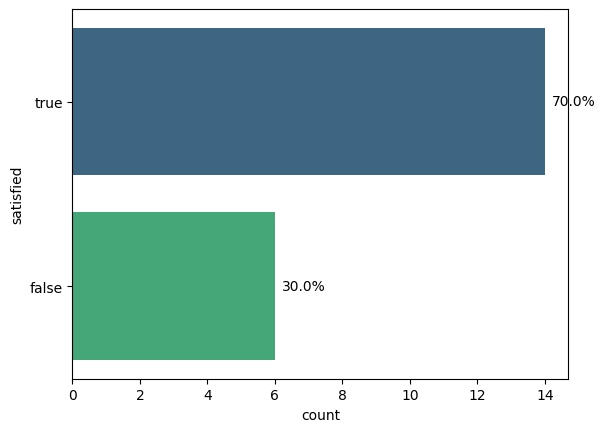

In [68]:
plot_judge_results(
    gold_standard_dspy_judge_results.to_pandas()
)

## Save gold standard result

In [70]:
data_loader.save_dataset_locally(
    gold_standard_dspy_judge_results,"datasets/gold_standard_judge_result"
)

Saving the dataset (1/1 shards): 100%|██████████| 20/20 [00:00<00:00, 3334.37 examples/s]
2025-11-06 21:52:29 - dspy_judge.data_loader.dataset_loader - INFO - Dataset saved to datasets/gold_standard_judge_result
Saving the dataset (1/1 shards): 100%|██████████| 20/20 [00:00<00:00, 3334.37 examples/s]
2025-11-06 21:52:29 - dspy_judge.data_loader.dataset_loader - INFO - Dataset saved to datasets/gold_standard_judge_result
